In [4]:
from mlguess.keras.models import CategoricalDNN
from bridgescaler.group import GroupStandardScaler, GroupMinMaxScaler, GroupRobustScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from hagelslag.evaluation.ProbabilityMetrics import DistributedReliability
from metpy.plots import add_metpy_logo, SkewT
from metpy.units import units
from hagelslag.evaluation.ProbabilityMetrics import DistributedROC
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition
from collections import Counter

In [9]:
def qc_mping(df, split_date, met_vars, output_cols, max_hgt_from_sfc=5000, hgt_interval=250, scaler_type='standard', exclude_months=None, rain_thresh=-1, snow_thresh=3, other_thresh=0, temp_crossings=(1, -2), filter='TEMP_C_0_m'):
    """
    df: Pandas Dataframe of sounding data and assiciated mping reports
    split_date (string): Date to split training and validation data
    met_vars (list): Prefix for Meteorlogical variables not include the height 
    ouput_cols (list): Output columns (p-types)
    max_hgt_from_sfc (int): Max level above the surface to for each variable (meters)
    hgt_interval (int): How many meters between each vetical level
    scaler_type (string): Tyhpe of group scaler to use (supports "standard", "robust", and "minmax")
    exclude_months (list of ints): Interger list of numeric months to remove from the dataset
    rain_thresh (int): Filter threshold to remove all rain observations BELOW this value
    snow_thresh (int): Filter threshold to remove all snow observations ABOVE this value
    other_thresh (int): Filter threshold to remove all IP and FRZR observations ABOVE this value
    temp_crossings (tuple): (max, min) Filter to ensure temperature profile crosses both of these thresholds in the vertical profile for IP and FRZR
    filter (string): Which input variable to use for thresholds
    """    
    def one_hot(x, output_cols):
        a = np.zeros(len(output_cols))
        a[x] = 1
        return a
    
    line_cross_filter = 'TEMP_C_0_m'
    scalar_objs = {"minmax": GroupMinMaxScaler, "standard": GroupStandardScaler, "robust": GroupRobustScaler}

    scaler = scalar_objs[scaler_type]()
    input_cols = [f'{var}_{height}_m' for var in met_vars for height in range(0, max_hgt_from_sfc + hgt_interval, hgt_interval)]
    groups = []
    for var in met_vars:
        groups.append([v for v in input_cols if var in v])
    
    data = {}
    mping = df.copy()
    mping['percent_max'] = mping[['ra_percent',
                                  'sn_percent',
                                  'pl_percent',
                                  'fzra_percent']].idxmax(axis=1)
    temps = [f"TEMP_C_{x}_m" for x in range(0, max_hgt_from_sfc + hgt_interval, hgt_interval)]
    dews = [f"T_DEWPOINT_C_{x}_m" for x in range(0, max_hgt_from_sfc + hgt_interval, hgt_interval)]
    
    if exclude_months:
        mping = mping[~mping['datetime'].dt.month.isin(exclude_months)]
    if snow_thresh is not None:
        snow = mping[((mping['percent_max'] == 'sn_percent') & (mping[filter] < snow_thresh))]
    if rain_thresh is not None:
        rain = mping[((mping['percent_max'] == 'ra_percent') & (mping[filter] > rain_thresh))]
    if other_thresh is not None:
        sleet = mping[(mping['percent_max'] == 'pl_percent') & (mping[temps].gt(temp_crossings[0]).any(axis=1)) & (mping[temps].lt(temp_crossings[1]).any(axis=1)) & (mping[filter] < other_thresh)]
        frain = mping[(mping['percent_max'] == 'fzra_percent') & (mping[temps].gt(temp_crossings[0]).any(axis=1)) & (mping[temps].lt(temp_crossings[1]).any(axis=1)) & (mping[filter] < other_thresh)]

    filtered_mping = pd.concat([rain, snow, sleet, frain], axis=0)   
    filtered_mping['encoded_target'] = filtered_mping[output_cols].idxmax(axis=1).apply(lambda x: one_hot(output_cols.index(x), output_cols))
    
    data['train'] = filtered_mping[filtered_mping['datetime'] < split_date]
    data['val'] = filtered_mping[filtered_mping['datetime'] >= split_date]
    data['train_x'] = scaler.fit_transform(data['train'][input_cols], groups=groups)

    data['train_y'] = data['train']['encoded_target']
    data['val_x'] = scaler.transform(data['val'][input_cols])
    data['val_y'] = data['val']['encoded_target']

    return data, scaler

In [10]:
%%time
df = pd.read_parquet('/glade/campaign/cisl/aiml/ai2es/winter_ptypes/ptype_qc/mPING_hourafter_interpolated_QC2.parquet')
data, scaler = qc_mping(df,
                        split_date='2020-06-01',
                        met_vars=['TEMP_C', 'T_DEWPOINT_C', 'UGRD_m/s', 'VGRD_m/s'],
                        output_cols=['ra_percent', 'sn_percent', 'pl_percent', 'fzra_percent'],
                        max_hgt_from_sfc=5000,
                        hgt_interval=250,
                        scaler_type='robust',
                        exclude_months=[5, 6, 7, 8, 9],
                        rain_thresh=-1,
                        snow_thresh=3,
                        other_thresh=0,
                        temp_crossings=(1, -2),
                        filter='wetbulb_temp_0m_C')
print(Counter(data['train']['percent_max']))

Counter({'ra_percent': 583906, 'sn_percent': 436818, 'pl_percent': 20548, 'fzra_percent': 19290})
CPU times: user 12.2 s, sys: 5.51 s, total: 17.7 s
Wall time: 22.5 s


In [6]:
model = CategoricalDNN( hidden_layers=3,
                        hidden_neurons=128,
                        evidential=True,
                        activation="leaky",
                        n_inputs=data['train_x'].shape[-1],
                        n_classes=4,
                        lr=0.00005,
                        use_dropout=True,
                        dropout_alpha=0.2,
                        batch_size=1024,
                        epochs=20,
                        verbose=1,
                        random_state=1000,
                        annealing_coeff=34)
model.fit(data['train_x'], np.stack(data['train_y']), shuffle=True, verbose=1)
probs, u, ale, epi = model.predict(data['val_x'], return_uncertainties=True, batch_size=5000)
preds = np.argmax(probs, axis=1)
obs = np.argmax(np.stack(data['val_y']), axis=1)
truth = np.argmax(np.stack(data['val_y']), axis=1)

2024-05-06 21:21:07.576581: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/20
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.4412
Epoch 2/20
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1749
Epoch 3/20
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1555
Epoch 4/20
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1421
Epoch 5/20
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1297
Epoch 6/20
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1233
Epoch 7/20
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1205
Epoch 8/20
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1185
Epoch 9/20
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1165
Epoch 10/20
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1149
Epoch 11/20
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1138
Epoch 12/20
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1134
Epoch 13/20
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1127
Epoch 14/20
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1124
Epoch 15/20
1036/1036 ━━━━━━━

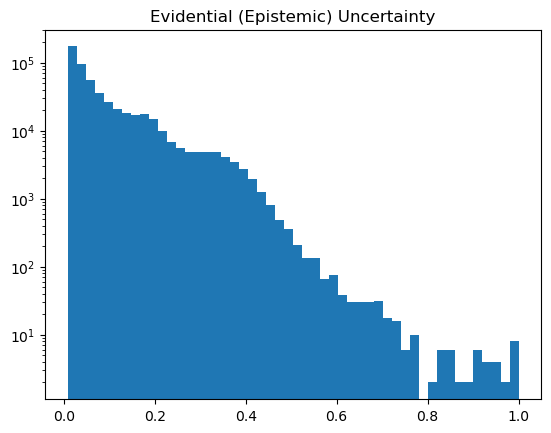

In [9]:
plt.hist(u.numpy().flatten(), bins=50, log=True)
plt.title("Evidential (Epistemic) Uncertainty")
plt.show()

Text(0.5, 0, 'mPING')

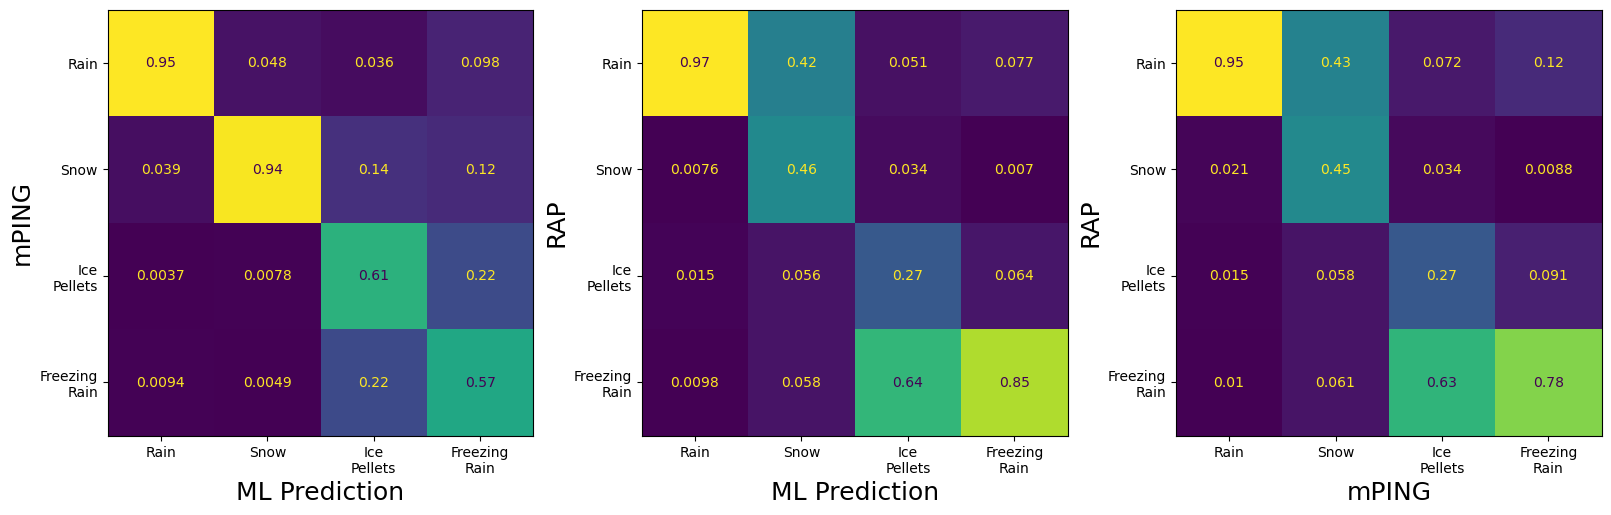

In [10]:
rap_precip_mask = data['val'][['CRAIN', 'CSNOW', 'CICEP', 'CFRZR']].sum(axis=1) > 0
rap_truth_all = np.zeros(len(preds))
for i, ptype in enumerate(['CRAIN', 'CSNOW', 'CICEP', 'CFRZR']):
    mask = data['val'][ptype] == 1
    rap_truth_all[mask] = i
rap_truth = rap_truth_all[rap_precip_mask]
mping_truth = np.argmax(np.stack(data['val_y']), axis=1)

fig, axes = plt.subplots(1, 3, figsize=(16, 6),layout="constrained")

ml_mping = confusion_matrix(mping_truth, preds, normalize='pred')
p = ConfusionMatrixDisplay(ml_mping, display_labels=['Rain', 'Snow', 'Ice\nPellets', 'Freezing\nRain']).plot(ax=axes[0], colorbar=False)
axes[0].set_ylabel('mPING', fontsize=18)
axes[0].set_xlabel('ML Prediction', fontsize=18)

ml_rap = confusion_matrix(rap_truth, preds[rap_precip_mask], normalize='pred')
p = ConfusionMatrixDisplay(ml_rap, display_labels=['Rain', 'Snow', 'Ice\nPellets', 'Freezing\nRain']).plot(ax=axes[1], colorbar=False)
axes[1].set_ylabel('RAP', fontsize=18)
axes[1].set_xlabel('ML Prediction', fontsize=18)

rap_mping = confusion_matrix(rap_truth, mping_truth[rap_precip_mask], normalize='pred')
p = ConfusionMatrixDisplay(rap_mping, display_labels=['Rain', 'Snow', 'Ice\nPellets', 'Freezing\nRain']).plot(ax=axes[2], colorbar=False)
axes[2].set_ylabel('RAP', fontsize=18)
axes[2].set_xlabel('mPING', fontsize=18)
# fig.savefig("/glade/derecho/scratch/cbecker/ptype_cm_20240424.png", dpi=300, bbox_inches='tight') 

In [99]:
def performance_diagram(roc_objs, obj_labels, colors, markers, filename, figsize=(8, 8),
                        xlabel="Success Ratio (1-FAR)",
                        ylabel="Probability of Detection", ticks=np.arange(0, 1.1, 0.1),
                        dpi=300, csi_cmap="Blues",
                        csi_label="Critical Success Index", title="Performance Diagram",
                        legend_params=None, bootstrap_sets=None, ci=(2.5, 97.5), label_fontsize=14,
                        title_fontsize=16, tick_fontsize=12):
    """
    Draws a performance diagram from a set of DistributedROC objects.

    A performance diagram is a variation on the ROC curve in which the Probability of False Detection on the
    x-axis has been replaced with the Success Ratio (1-False Alarm Ratio or Precision). The diagram also shows
    the Critical Success Index (CSI or Threat Score) as a series of curved contours, and the frequency bias as
    angled diagonal lines. Points along the 1:1 diagonal are unbiased, and better performing models should appear
    in the upper right corner. The performance diagram is particularly useful for displaying verification for
    severe weather warnings as it displays all three commonly used statistics (POD, FAR, and CSI) simultaneously
    on the same chart.

    Args:
        roc_objs (list): DistributedROC objects being plotted.
        obj_labels: list or array of labels describing each DistributedROC object.
        obj_labels (list): Label describing the forecast associated with a DistributedROC object.
        colors (list): List of matplotlib-readable colors (names or hex-values) for each curve.
        markers (list): Matplotlib marker (e.g. *, o, v, etc.) for each curve.
        filename (str): Name of figure file being saved.
        figsize (tuple): (Width, height) of the figure in inches.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        title (str): The title of the figure.
        ticks (numpy.ndarray): Values shown on the x and y axes.
        dpi (int): Figure resolution in dots per inch.
        csi_cmap (str): Matplotlib colormap used to fill CSI contours.
        csi_label (str): Label for CSI colormap.
        legend_params (None or dict): Keyword arguments for the formatting of the figure legend.
        bootstrap_sets (list): A list of arrays of bootstrapped DistributedROC objects. If not None,
            confidence regions will be plotted.
        ci (tuple): tuple of bootstrap confidence interval percentiles.
        label_fontsize (int): Font size of the x and y axis labels.
        title_fontsize (int): Font size of the title.
        tick_fontsize (int): Font size of the x and y tick labels.

    Examples:

        >>> from hagelslag.evaluation.ProbabilityMetrics import DistributedROC
        >>> import numpy as np
        >>> forecasts = np.random.random(1000)
        >>> obs = np.random.random_integers(0, 1, 1000)
        >>> roc = DistributedROC()
        >>> roc.update(forecasts, obs)
        >>> performance_diagram([roc], ["Random"], ["orange"], ["o"], "random_performance.png")
    """
    if legend_params is None:
        legend_params = dict(loc=4, fontsize=10, framealpha=1, frameon=True)
    # fig = plt.figure(figsize=figsize)
    fig.add_subplot(121)
    grid_ticks = np.arange(0, 1.01, 0.01)
    sr_g, pod_g = np.meshgrid(grid_ticks, grid_ticks)
    bias = pod_g / sr_g
    csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)
    csi_contour = plt.contourf(sr_g, pod_g, csi, np.arange(0.1, 1.1, 0.1), extend="max", cmap=csi_cmap)
    b_contour = plt.contour(sr_g, pod_g, bias, [0.5, 1, 1.5, 2, 4], colors="k", linestyles="dashed")
    plt.clabel(b_contour, fmt="%1.1f", manual=[(0.2, 0.9), (0.4, 0.9), (0.6, 0.9), (0.7, 0.7)])
    if bootstrap_sets is not None:
        for b, b_set in enumerate(bootstrap_sets):
            perf_curves = np.dstack([b_roc.performance_curve().values for b_roc in b_set])
            pod_range = np.nanpercentile(perf_curves[:, 0], ci, axis=1)
            sr_range = np.nanpercentile(1 - perf_curves[:, 1], ci, axis=1)
            pod_poly = np.concatenate((pod_range[1], pod_range[0, ::-1]))
            sr_poly = np.concatenate((sr_range[1], sr_range[0, ::-1]))
            pod_poly[np.isnan(pod_poly)] = 0
            sr_poly[np.isnan(sr_poly)] = 1
            plt.fill(sr_poly, pod_poly, alpha=0.5, color=colors[b])
    linestyles = ['-', '-', '-', '-', '--', '--', '--', '--']
    for r, roc_obj in enumerate(roc_objs):
        perf_data = roc_obj.performance_curve()
        if r > 3:
            alpha = 0.4
        else:
            alpha = 1
        pp = plt.plot(1 - perf_data["FAR"], perf_data["POD"], marker=markers[r], linestyle=linestyles[r], color=colors[r], label=obj_labels[r], alpha=alpha)
    cbar = plt.colorbar(csi_contour)
    cbar.set_label(csi_label)
    plt.xlabel(xlabel, fontsize=label_fontsize)
    plt.ylabel(ylabel, fontsize=label_fontsize)
    plt.xticks(ticks, fontsize=tick_fontsize)
    plt.yticks(ticks, fontsize=tick_fontsize)
    plt.title(title, fontsize=title_fontsize)
    plt.legend(**legend_params)
    plt.savefig(filename, dpi=dpi, bbox_inches="tight")
    return pp

def attributes_diagram2(rel_objs, obj_labels, colors, markers, filename, figsize=(8, 8), xlabel="Forecast Probability",
                       ylabel="Observed Relative Frequency", ticks=np.arange(0, 1.1, 0.1), dpi=300,
                       title="Attributes Diagram", legend_params=None, inset_params=None,
                       inset_position=(0.12, 0.72, 0.25, 0.25), bootstrap_sets=None, ci=(2.5, 97.5)):
    """
    Plot reliability curves against a 1:1 diagonal to determine if probability forecasts are consistent with their
    observed relative frequency. Also adds gray areas to show where the climatological probabilities lie and what
    areas result in a positive Brier Skill Score.

    Args:
        rel_objs (list): List of DistributedReliability objects.
        obj_labels (list): List of labels describing the forecast model associated with each curve.
        colors (list): List of colors for each line
        markers (list): List of line markers
        filename (str): Where to save the figure.
        figsize (tuple): (Width, height) of the figure in inches.
        xlabel (str): X-axis label
        ylabel (str): Y-axis label
        ticks (`numpy.ndarray`): Tick value labels for the x and y axes.
        dpi (int): resolution of the saved figure in dots per inch.
        title (str): Title of figure
        legend_params (dict): Keyword arguments for the plot legend.
        inset_params (dict): Keyword arguments for the inset axis.
        inset_position (tuple): Position of the inset axis in normalized axes coordinates (left, bottom, width, height)
        bootstrap_sets (list): A list of arrays of bootstrapped DistributedROC objects. If not None,
            confidence regions will be plotted.
        ci (tuple): tuple of bootstrap confidence interval percentiles
    """
    if legend_params is None:
        legend_params = dict(loc=4, fontsize=10, framealpha=1, frameon=True)
    if inset_params is None:
        inset_params = dict(width="25%", height="25%", loc=2, axes_kwargs=dict(facecolor='white'))
    # fig, ax = plt.subplots(figsize=figsize)
    fig.add_subplot(122)
    ax = fig.gca()

    plt.plot(ticks, ticks, "k--")
    # inset_hist = inset_axes(ax, **inset_params)
    # ip = InsetPosition(ax, inset_position)
    # inset_hist.set_axes_locator(ip)
    climo = rel_objs[0].climatology()
    no_skill = 0.5 * ticks + 0.5 * climo
    skill_x = [climo, climo, 1, 1, climo, climo, 0, 0, climo]
    skill_y = [climo, 1, 1, no_skill[-1], climo, 0, 0, no_skill[0], climo]
    f = plt.fill(skill_x, skill_y, "0.8")
    f[0].set_zorder(1)
    plt.plot(ticks, np.ones(ticks.shape) * climo, "k--")
    if bootstrap_sets is not None:
        for b, b_set in enumerate(bootstrap_sets):
            brel_curves = np.vstack([b_rel.reliability_curve()["Positive_Relative_Freq"].values for b_rel in b_set])
            rel_range = np.nanpercentile(brel_curves, ci, axis=0)
            fb = plt.fill_between(b_set[0].thresholds[:-1], rel_range[1], rel_range[0], alpha=0.5, color=colors[b])
            fb.set_zorder(2)
    linestyles = ['-', '-', '-', '-', '--', '--', '--', '--']

    for r, rel_obj in enumerate(rel_objs):
        if r > 3:
            alpha = 0.4
        else:
            alpha = 1
        rel_curve = rel_obj.reliability_curve()
        plt.plot(rel_curve["Bin_Start"], rel_curve["Positive_Relative_Freq"], color=colors[r],
                marker=markers[r], linestyle=linestyles[r], label=obj_labels[r], alpha=alpha)
    #     inset_hist.semilogy(rel_curve["Bin_Start"] * 100, rel_obj.frequencies["Total_Freq"][:-1], color=colors[r],
    #                         marker=markers[r])
    # inset_hist.set_xlabel("Forecast Probability")
    # inset_hist.set_ylabel("Frequency")
    # ax = plt.gca()
    plt.annotate("No Skill", (0.6, no_skill[6]), rotation=22.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(ticks)
    ax.set_xticklabels((ticks * 100).astype(int))
    plt.yticks(ticks)
    ax.set_yticklabels((ticks * 100).astype(int))
    plt.legend(**legend_params)
    ax.set_title(title, fontsize=18)
    # plt.savefig(filename, dpi=dpi, bbox_inches="tight")

/glade/derecho/scratch/cbecker/tmp/ipykernel_51124/497208453.py:58: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
/glade/derecho/scratch/cbecker/tmp/ipykernel_51124/497208453.py:58: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
/glade/derecho/scratch/cbecker/tmp/ipykernel_51124/497208453.py:59: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


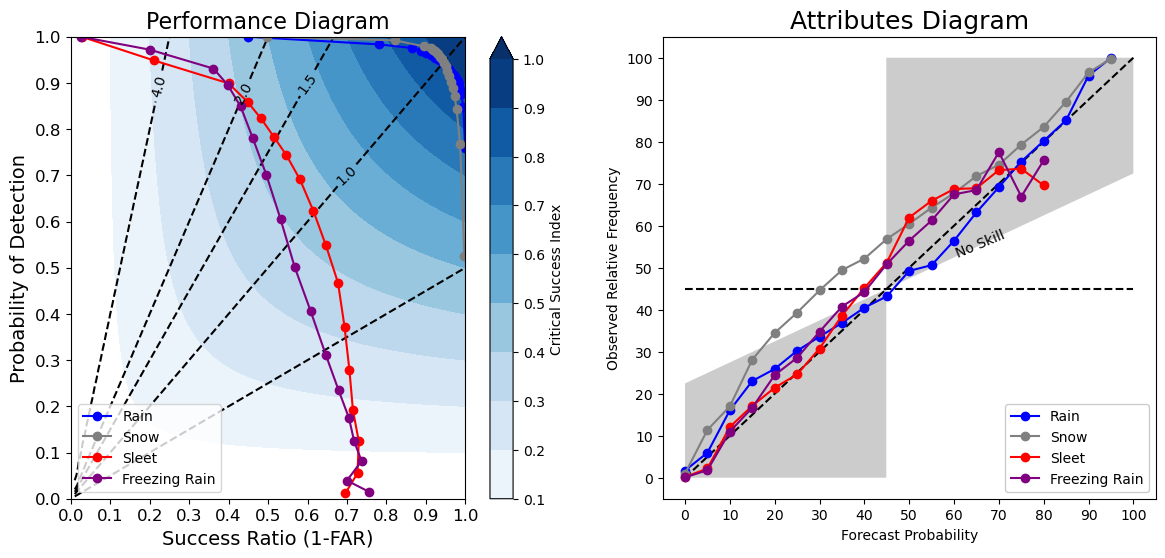

In [100]:
rocs = []
for i in range(4):
    forecasts = probs[:, i]
    obs = np.where(truth == i, 1, 0)
    roc = DistributedROC(thresholds=np.arange(0.0, 1.05, 0.05), obs_threshold=0.5)
    roc.update(forecasts, obs)
    rocs.append(roc)
# for i in range(4):
#     forecasts = probs_unfiltered[:, i]
#     obs = np.where(truth_unfiltered == i, 1, 0)
#     roc = DistributedROC(thresholds=np.arange(0.0, 1.05, 0.05), obs_threshold=0.5)
#     roc.update(forecasts, obs)
#     rocs.append(roc)

rels = []
for i in range(4):
    forecasts = probs[:, i]
    obs = np.where(truth == i, 1, 0)
    rel = DistributedReliability()
    rel.update(forecasts, obs)
    rels.append(rel)
    
fig = plt.figure(figsize=(14, 6))

p=performance_diagram(rocs, ['Rain','Snow','Sleet','Freezing Rain', None, None, None, None], ["blue", "grey", "red", "purple", "blue", "grey", "red", "purple"], ["o"]*8,
                    "/glade/work/cbecker/ptype-physical/ptype_performance_diagram_test2", legend_params={'loc': 'lower left'})
attributes_diagram2(rels, ['Rain', 'Snow', 'Sleet', 'Freezing Rain'], ["blue", "grey", "red", "purple"], ["o"]*4, "/glade/work/cbecker/ptype-physical/ptype_attributes_diagram_compare_test")
plt.show()
fig.savefig("/glade/derecho/scratch/cbecker/ptype_perf_attr_filtered_20240424.png", dpi=300, bbox_inches='tight') 

In [62]:
data_unfiltered, scaler_unfiltered = load_and_process_mping('/glade/p/cisl/aiml/ai2es/winter_ptypes/ptype_qc/mPING_hourafter_interpolated_QC2.parquet',
                                      split_date='2020-06-01',
                                      atm_vars=["TEMP_C", "T_DEWPOINT_C"],
                                      output_cols=['ra_percent', 'sn_percent', 'pl_percent', 'fzra_percent'],
                                      min_height=0,
                                      max_height=5000,
                                      resolution=250,
                                      scaler_type='robust',
                                      exclude_months=None,
                                      frozen_wetbulb_thresh=None,
                                      warm_thresh=None,
                                      frozen_thresh=None,
                                      filter_column=None)

In [70]:
model_unfiltered = CategoricalDNN(hidden_layers=3,
                                  hidden_neurons=128,
                                  evidential=True,
                                  activation="leaky",
                                  n_inputs=data_unfiltered['train_x'].shape[-1],
                                  n_classes=4,
                                  lr=0.00005,
                                  use_dropout=True,
                                  dropout_alpha=0.2,
                                  batch_size=1024,
                                  epochs=20,
                                  verbose=1,
                                  random_state=1000,
                                  annealing_coeff=34)
model_unfiltered.fit(data_unfiltered['train_x'], np.stack(data_unfiltered['train_y']), shuffle=True, verbose=1)
probs_unfiltered, u_unfiltered, ale_unfiltered, epi_unfiltered = model_unfiltered.predict(data_unfiltered['val_x'], return_uncertainties=True, batch_size=5000)
preds_unfiltered = np.argmax(probs_unfiltered, axis=1)
obs_unfiltered = np.argmax(np.stack(data_unfiltered['val_y']), axis=1)
truth_unfiltered = np.argmax(np.stack(data_unfiltered['val_y']), axis=1)

Epoch 1/20
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.3899
Epoch 2/20
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.2064
Epoch 3/20
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1881
Epoch 4/20
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1847
Epoch 5/20
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1819
Epoch 6/20
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.1804
Epoch 7/20
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1796
Epoch 8/20
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1784
Epoch 9/20
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1774
Epoch 10/20
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1775
Epoch 11/20
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1768
Epoch 12/20
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1763
Epoch 13/20
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.1758
Epoch 14/20
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.1762
Epoch 15/20
1670/1670 ━━━━━━━

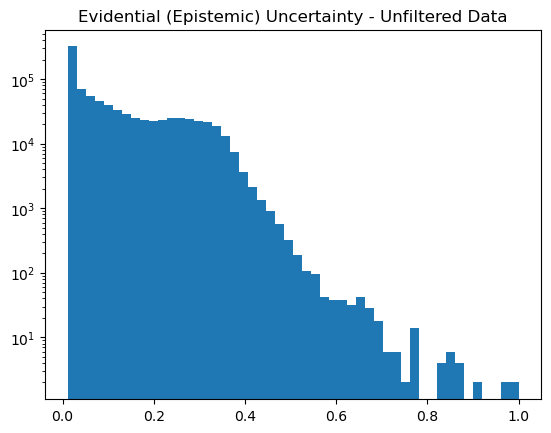

In [71]:
plt.hist(u_unfiltered.numpy().flatten(), bins=50, log=True)
plt.title("Evidential (Epistemic) Uncertainty - Unfiltered Data")
plt.show()

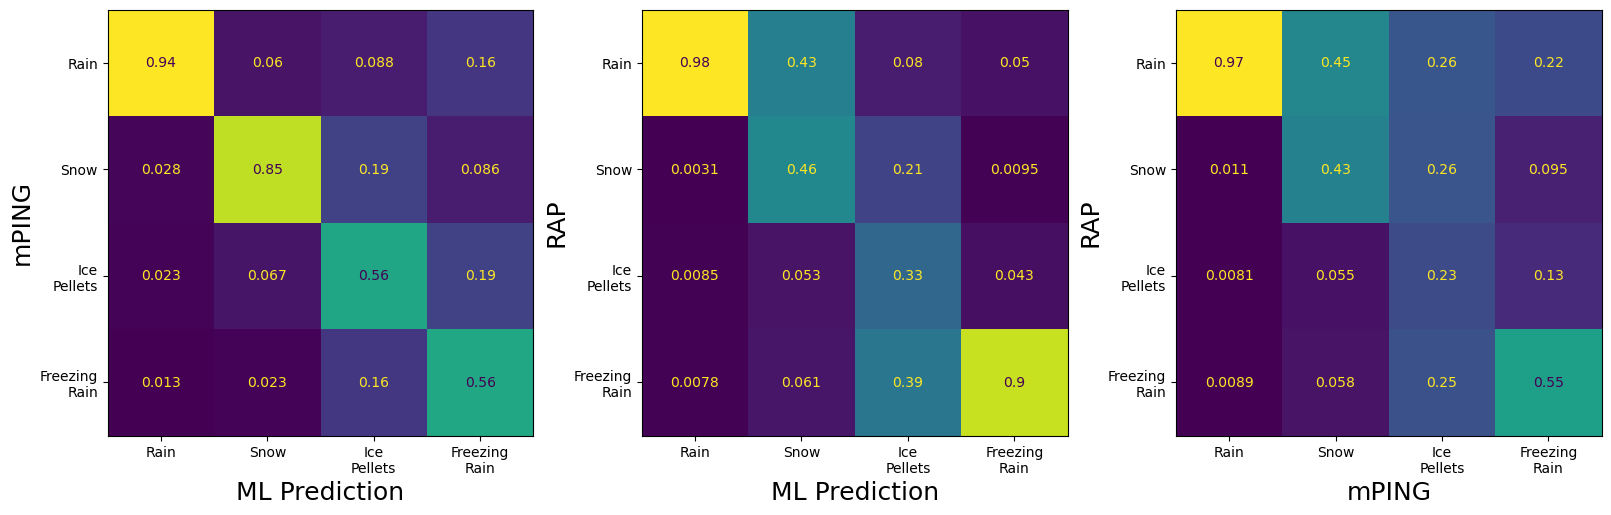

In [109]:
rap_precip_mask = data_unfiltered['val'][['CRAIN', 'CSNOW', 'CICEP', 'CFRZR']].sum(axis=1) > 0
rap_truth_all = np.zeros(len(preds_unfiltered))
for i, ptype in enumerate(['CRAIN', 'CSNOW', 'CICEP', 'CFRZR']):
    mask = data_unfiltered['val'][ptype] == 1
    rap_truth_all[mask] = i
rap_truth = rap_truth_all[rap_precip_mask]
mping_truth = np.argmax(np.stack(data_unfiltered['val_y']), axis=1)

fig, axes = plt.subplots(1, 3, figsize=(16, 6),layout="constrained")

ml_mping = confusion_matrix(mping_truth, preds_unfiltered, normalize='pred')
p = ConfusionMatrixDisplay(ml_mping, display_labels=['Rain', 'Snow', 'Ice\nPellets', 'Freezing\nRain']).plot(ax=axes[0], colorbar=False)
axes[0].set_ylabel('mPING', fontsize=18)
axes[0].set_xlabel('ML Prediction', fontsize=18)

ml_rap = confusion_matrix(rap_truth, preds_unfiltered[rap_precip_mask], normalize='pred')
p = ConfusionMatrixDisplay(ml_rap, display_labels=['Rain', 'Snow', 'Ice\nPellets', 'Freezing\nRain']).plot(ax=axes[1], colorbar=False)
axes[1].set_ylabel('RAP', fontsize=18)
axes[1].set_xlabel('ML Prediction', fontsize=18)

rap_mping = confusion_matrix(rap_truth, mping_truth[rap_precip_mask], normalize='pred')
p = ConfusionMatrixDisplay(rap_mping, display_labels=['Rain', 'Snow', 'Ice\nPellets', 'Freezing\nRain']).plot(ax=axes[2], colorbar=False)
axes[2].set_ylabel('RAP', fontsize=18)
axes[2].set_xlabel('mPING', fontsize=18)
fig.savefig("/glade/derecho/scratch/cbecker/ptype_cm_unfiltered_20240424.png", dpi=300, bbox_inches='tight') 

/glade/derecho/scratch/cbecker/tmp/ipykernel_75747/497208453.py:58: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
/glade/derecho/scratch/cbecker/tmp/ipykernel_75747/497208453.py:58: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
/glade/derecho/scratch/cbecker/tmp/ipykernel_75747/497208453.py:59: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


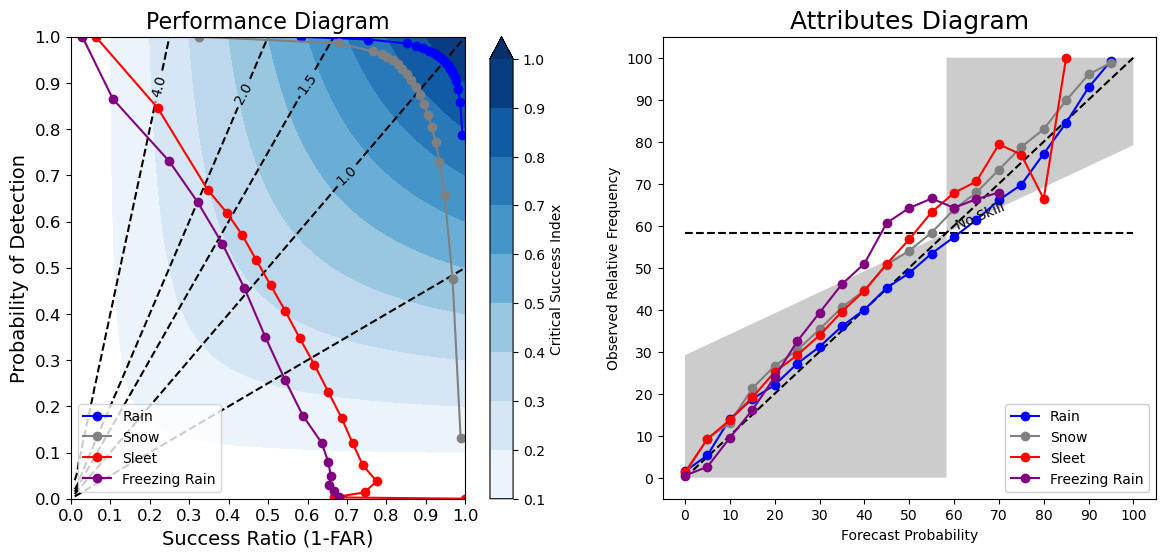

In [108]:
rocs = []
for i in range(4):
    forecasts_unfiltered = probs_unfiltered[:, i]
    obs_unfiltered = np.where(truth_unfiltered == i, 1, 0)
    roc = DistributedROC(thresholds=np.arange(0.0, 1.05, 0.05), obs_threshold=0.5)
    roc.update(forecasts_unfiltered, obs_unfiltered)
    rocs.append(roc)
# for i in range(4):
#     forecasts = probs_unfiltered[:, i]
#     obs = np.where(truth_unfiltered == i, 1, 0)
#     roc = DistributedROC(thresholds=np.arange(0.0, 1.05, 0.05), obs_threshold=0.5)
#     roc.update(forecasts, obs)
#     rocs.append(roc)

rels = []
for i in range(4):
    forecasts_unfiltered = probs_unfiltered[:, i]
    obs_unfiltered = np.where(truth_unfiltered == i, 1, 0)
    rel = DistributedReliability()
    rel.update(forecasts_unfiltered, obs_unfiltered)
    rels.append(rel)
    
fig = plt.figure(figsize=(14, 6))

p=performance_diagram(rocs, ['Rain','Snow','Sleet','Freezing Rain', None, None, None, None], ["blue", "grey", "red", "purple", "blue", "grey", "red", "purple"], ["o"]*8,
                    "/glade/work/cbecker/ptype-physical/ptype_performance_diagram_test2", legend_params={'loc': 'lower left'})
attributes_diagram2(rels, ['Rain', 'Snow', 'Sleet', 'Freezing Rain'], ["blue", "grey", "red", "purple"], ["o"]*4, "/glade/work/cbecker/ptype-physical/ptype_attributes_diagram_compare_test")
plt.show()
fig.savefig("/glade/derecho/scratch/cbecker/ptype_perf_attrs_unfiltered_20240424.png", dpi=300, bbox_inches='tight') 

/glade/derecho/scratch/cbecker/tmp/ipykernel_75747/497208453.py:58: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
/glade/derecho/scratch/cbecker/tmp/ipykernel_75747/497208453.py:58: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
/glade/derecho/scratch/cbecker/tmp/ipykernel_75747/497208453.py:59: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


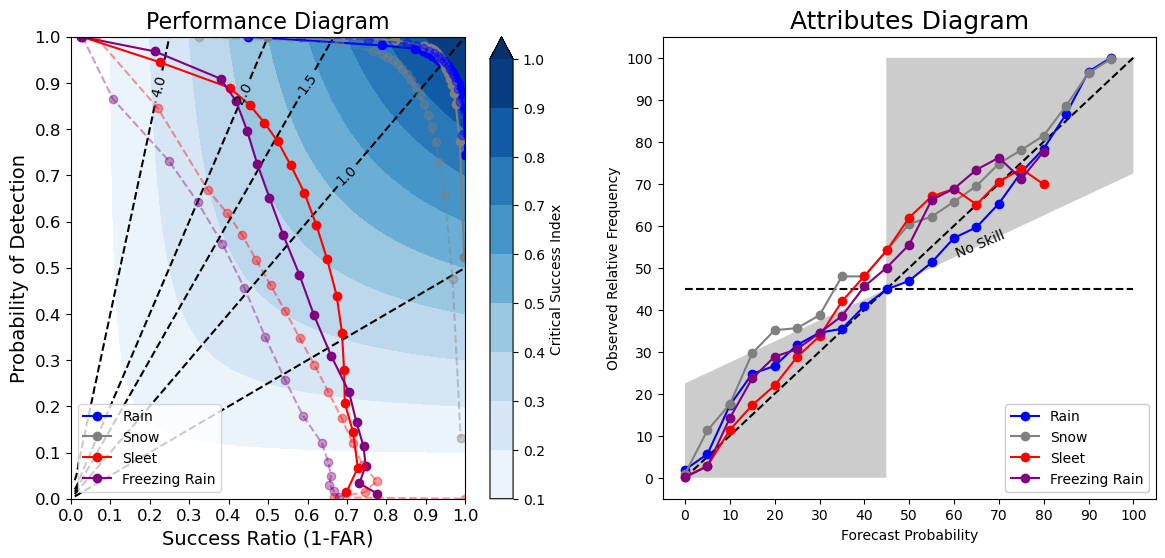

In [107]:
rocs = []
for i in range(4):
    forecasts = probs[:, i]
    obs = np.where(truth == i, 1, 0)
    roc = DistributedROC(thresholds=np.arange(0.0, 1.05, 0.05), obs_threshold=0.5)
    roc.update(forecasts, obs)
    rocs.append(roc)
for i in range(4):
    forecasts = probs_unfiltered[:, i]
    obs = np.where(truth_unfiltered == i, 1, 0)
    roc = DistributedROC(thresholds=np.arange(0.0, 1.05, 0.05), obs_threshold=0.5)
    roc.update(forecasts, obs)
    rocs.append(roc)

rels = []
for i in range(4):
    forecasts = probs[:, i]
    obs = np.where(truth == i, 1, 0)
    rel = DistributedReliability()
    rel.update(forecasts, obs)
    rels.append(rel)
    
fig = plt.figure(figsize=(14, 6))

p=performance_diagram(rocs, ['Rain','Snow','Sleet','Freezing Rain', None, None, None, None], ["blue", "grey", "red", "purple", "blue", "grey", "red", "purple"], ["o"]*8,
                    "/glade/work/cbecker/ptype-physical/ptype_performance_diagram_test2", legend_params={'loc': 'lower left'})
attributes_diagram2(rels, ['Rain', 'Snow', 'Sleet', 'Freezing Rain'], ["blue", "grey", "red", "purple"], ["o"]*4, "/glade/work/cbecker/ptype-physical/ptype_attributes_diagram_compare_test")
plt.show()
fig.savefig("/glade/derecho/scratch/cbecker/ptype_perf_attrs_combined_20240424.png", dpi=300, bbox_inches='tight')

In [84]:
## filtered
press = [f'PRES_Pa_{h}_m' for h in np.arange(0, 5250, 250)]
p = data['val'].iloc[0][press].values * units.hPa
truth = np.argmax(np.stack(data['val_y']), axis=1)
temps = [f"TEMP_C_{x}_m" for x in range(0, 5250, 250)]
dews = [f"T_DEWPOINT_C_{x}_m" for x in range(0, 5250, 250)]
post_data = scaler.inverse_transform(data['val_x'].copy(deep=True))
post_data = pd.concat([data['val'][press], post_data], axis=1) 
post_data['truth'] = truth
post_data['pred'] = preds
post_data['u'] = u.numpy().flatten()
t_comp_truth = post_data.groupby('truth').median()[temps]
d_comp_truth = post_data.groupby('truth').median()[dews]
t_comp_preds = post_data.groupby('pred').median()[temps]
d_comp_preds = post_data.groupby('pred').median()[dews]
t_pred_quantile_10 = post_data.groupby('pred').quantile(0.10)[temps]
t_pred_quantile_90 = post_data.groupby('pred').quantile(0.90)[temps]

In [85]:
def skewCompositeFigAx(figsize=(5, 5), num_subplots=1, rows=1, cols=None):
    # fig ax setup for skewx fig
    # returns top subfigure and a list of axs lists

    if (num_subplots > 1) and (figsize == (5, 5)):
        figsize = (10, 5)
    if cols:  # add blank subplots below
        num_subplots = cols

    fig = plt.figure(figsize=figsize)
    sfigs = fig.subfigures(rows, 1)
    if rows == 1:
        sfigs = [sfigs]

    skew_axs = sfigs[0].subplots(
        1, num_subplots, sharey=True, subplot_kw=dict(projection="skewx", rotation=30)
    )
    if num_subplots == 1:
        skew_axs = [skew_axs]

    axs = skew_axs
    if num_subplots == 1:
        axs = [axs]
    if rows > 1:
        t_axs = sfigs[1].subplots(1, num_subplots, sharex=True)
        axs = [skew_axs, t_axs]

    skew_axs[0].set_ylabel("Height above ground (m)", fontsize=10)
    for ax in skew_axs:
        ax.grid(which="both")

        major_ticks = np.arange(-100, 100, 5)
        ax.set_xticks(major_ticks)
        ax.grid(which="major", alpha=0.5)

        # minor_ticks = np.arange(xlowlim - 60, xhighlim, 1)
        # ax.set_xticks(minor_ticks, minor=True)
        # ax.grid(which='minor', alpha=0.2)

        ax.axvline(x=0, ymin=0, ymax=1, c="0")
        ax.set_ylim(-100, 5100)
        ax.set_xlim(-10, 25)
    if rows == 1:
        axs = skew_axs
    return sfigs[0], axs

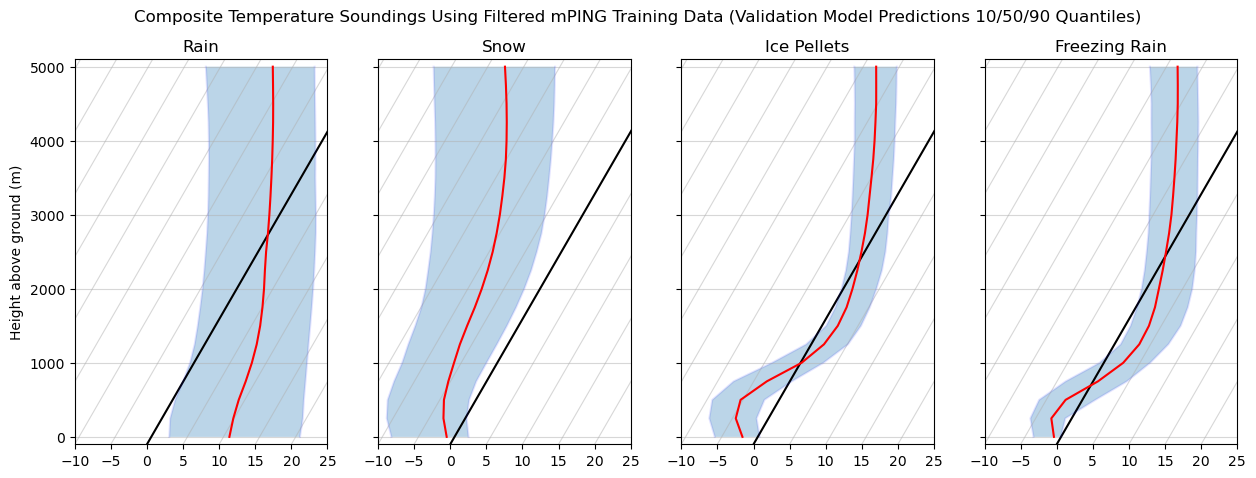

In [97]:
# h = data["heightAboveGround"].values * units.hPa
# t = data["t_h"][0, 0, :].values * units.degree_Celsius
# td = data["dpt_h"][0, 0, :].values * units.degree_Celsius
ptypes = {0: 'Rain', 1: 'Snow', 2: 'Ice Pellets', 3: "Freezing Rain"}
vertical_atm = np.arange(0, 5250, 250)
fig, axs = skewCompositeFigAx(figsize=(15, 5), num_subplots=4)
for i, p in ptypes.items():
    axs[i].plot(t_comp_preds.loc[i], vertical_atm, "r")
    axs[i].plot(t_pred_quantile_10.loc[i], vertical_atm, "b", alpha=0.1)
    axs[i].plot(t_pred_quantile_90.loc[i], vertical_atm, "b", alpha=0.1)
    axs[i].fill_betweenx(vertical_atm, t_pred_quantile_10.loc[i], t_pred_quantile_90.loc[i], alpha=0.3)
    axs[i].set_title(p)
fig.suptitle('Composite Temperature Soundings Using Filtered mPING Training Data (Validation Model Predictions 10/50/90 Quantiles)', fontsize=12)
plt.savefig("/glade/derecho/scratch/cbecker/composite_soundings_filtered_20240506.png", dpi=300, bbox_inches="tight")

In [87]:
## unfiltered
press = [f'PRES_Pa_{h}_m' for h in np.arange(0, 5250, 250)]
p = data_unfiltered['val'].iloc[0][press].values * units.hPa
truth_unfiltered = np.argmax(np.stack(data_unfiltered['val_y']), axis=1)
temps_unfiltered = [f"TEMP_C_{x}_m" for x in range(0, 5250, 250)]
dews_unfiltered = [f"T_DEWPOINT_C_{x}_m" for x in range(0, 5250, 250)]
post_data_unfiltered = scaler.inverse_transform(data_unfiltered['val_x'].copy(deep=True))
post_data_unfiltered = pd.concat([data_unfiltered['val'][press], post_data_unfiltered], axis=1) 
post_data_unfiltered['truth'] = truth_unfiltered
post_data_unfiltered['pred'] = preds_unfiltered
post_data_unfiltered['u'] = u_unfiltered.numpy().flatten()
t_comp_truth_unfiltered = post_data_unfiltered.groupby('truth').median()[temps_unfiltered]
d_comp_truth_unfiltered = post_data_unfiltered.groupby('truth').median()[dews_unfiltered]
t_comp_preds_unfiltered = post_data_unfiltered.groupby('pred').median()[temps_unfiltered]
d_comp_preds_unfiltered = post_data_unfiltered.groupby('pred').median()[dews_unfiltered]
t_pred_quantile_10_unfiltered = post_data_unfiltered.groupby('pred').quantile(0.10)[temps_unfiltered]
t_pred_quantile_90_unfiltered = post_data_unfiltered.groupby('pred').quantile(0.90)[temps_unfiltered]

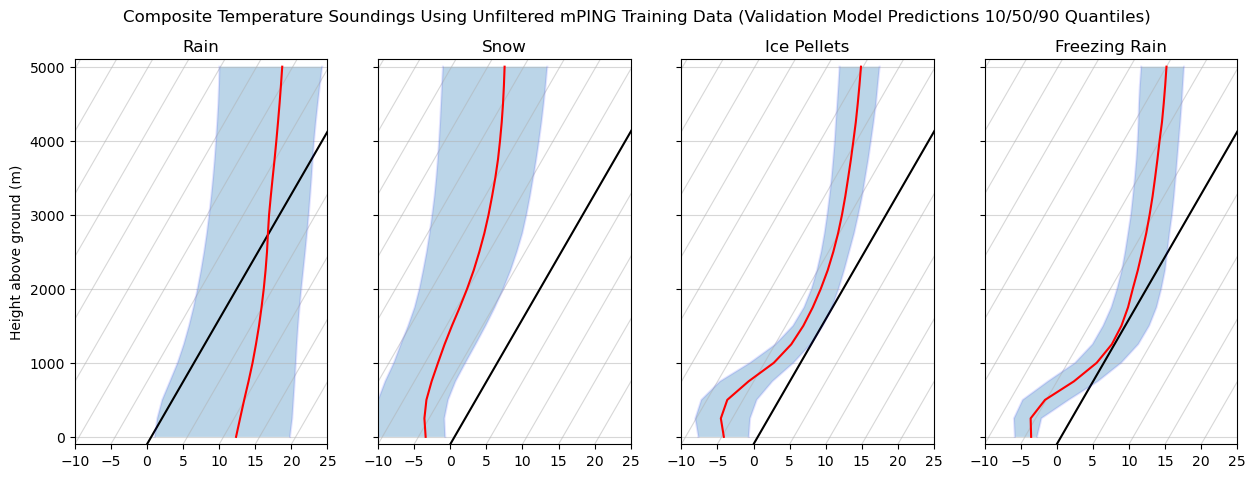

In [96]:
ptypes = {0: 'Rain', 1: 'Snow', 2: 'Ice Pellets', 3: "Freezing Rain"}
vertical_atm = np.arange(0, 5250, 250)
fig, axs = skewCompositeFigAx(figsize=(15, 5), num_subplots=4)
for i, p in ptypes.items():
    axs[i].plot(t_comp_preds_unfiltered.loc[i], vertical_atm, "r")
    axs[i].plot(t_pred_quantile_10_unfiltered.loc[i], vertical_atm, "b", alpha=0.1)
    axs[i].plot(t_pred_quantile_90_unfiltered.loc[i], vertical_atm, "b", alpha=0.1)
    axs[i].fill_betweenx(vertical_atm, t_pred_quantile_10_unfiltered.loc[i], t_pred_quantile_90_unfiltered.loc[i], alpha=0.3)
    axs[i].set_title(p)
fig.suptitle('Composite Temperature Soundings Using Unfiltered mPING Training Data (Validation Model Predictions 10/50/90 Quantiles)', fontsize=12)
plt.savefig("/glade/derecho/scratch/cbecker/composite_soundings_unfiltered_20240506.png", dpi=300, bbox_inches="tight")